In [1]:
import seaborn as sns
import itertools
from scipy import stats
import tensorflow as tf
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import cPickle as pickle
import os
import seaborn as sns
from IPython.display import Image, display
from sklearn import metrics


sns.set_style("white")
sns.set_palette("husl")

In [93]:
def format_plot(xlabel, ylabel, label_size=10, grid=False):
    plt.tick_params(axis='y', which='major', labelsize=label_size * 1.4)
    plt.tick_params(axis='y', which='minor', labelsize=label_size * 1.2)
    plt.tick_params(axis='x', which='major', labelsize=label_size * 1.4)
    plt.tick_params(axis='x', which='minor', labelsize=label_size * 1.2)

    plt.xlabel(xlabel, fontsize=label_size * 1.6)
    plt.ylabel(ylabel, fontsize=label_size * 1.6)
    plt.tight_layout()
    plt.gca().xaxis.grid(grid)
    plt.gca().yaxis.grid(grid)
    leg = plt.legend(loc=0, frameon=1, prop={'size': label_size * 1.2})
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)
        
def write_file(plot_file_prefix, show=False):

    plot_file = "{}.pdf".format(plot_file_prefix)
    plt.savefig(plot_file)
    
    print(plot_file)
    
    plot_file = "{}.png".format(plot_file_prefix)
    plt.savefig(plot_file, format="png", dpi=1000)
    
    if show:
        plt.show()
        
    plt.clf()

                
                

In [94]:
def plot_guesses(expname, filename, plot_dir):
    with open(filename) as f:
        predictions_by_imageid = {}
        actuals_by_imageid = {}
        epochs_by_imageid = {}
        for line in f:
            if "prediction" in line:
                vals = line.split(",")
                image_id = int(vals[1])
                if image_id not in predictions_by_imageid.keys():
                    predictions_by_imageid[image_id] = []
                    actuals_by_imageid[image_id] = []
                    epochs_by_imageid[image_id] = []
                predictions_by_imageid[image_id].append(float(vals[3]))
                actuals_by_imageid[image_id].append(float(vals[4]))
                epochs_by_imageid[image_id].append(int(vals[2]))
    max_ids = 100
    for image_id in predictions_by_imageid.keys():
        epochs = epochs_by_imageid[image_id]
        predictions = predictions_by_imageid[image_id]
        actuals = actuals_by_imageid[image_id]
        plt.scatter(epochs, actuals, linestyle="-", label="Actual")
        plt.scatter(epochs, predictions, linestyle="--", label="Prediction")
        
        plt.ylim(0, 1)
        format_plot("Epoch", "Probability")
        output_dir = os.path.join(plot_dir, expname)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        output_prefix = "{}/image-{}".format(output_dir, image_id)
        write_file(output_prefix)
        if image_id >= max_ids:
            break    
            
                
                

In [106]:
def plot_guesses_tmp(expname, filename, plot_dir):
    selects_filename = "{}_selects".format(filename)
    select_marker = "."
    skip_marker = "+"
    with open(filename) as f:
        predictions_by_imageid = {}
        actuals_by_imageid = {}
        epochs_by_imageid = {}
        markers_by_imageid = {}
        for line in f:
            if "prediction" in line:
                vals = line.split(",")
                image_id = int(vals[1])
                if image_id not in predictions_by_imageid.keys():
                    predictions_by_imageid[image_id] = []
                    actuals_by_imageid[image_id] = []
                    epochs_by_imageid[image_id] = []
                    markers_by_imageid[image_id] = []
                predictions_by_imageid[image_id].append(float(vals[3]))
                actuals_by_imageid[image_id].append(float(vals[4]))
                epochs_by_imageid[image_id].append(int(vals[2]))
    with open(selects_filename) as f:
        for line in f:
            if "prediction" in line:
                vals = line.split(",")
                image_id = int(vals[1])
                select = int(vals[-1])
                if image_id not in predictions_by_imageid.keys():
                    continue
                if select:
                    markers_by_imageid[image_id].append(select_marker)
                else:
                    markers_by_imageid[image_id].append(skip_marker)
    max_ids = 100
    for image_id in predictions_by_imageid.keys():
        epochs = np.array(epochs_by_imageid[image_id])
        predictions = np.array(predictions_by_imageid[image_id])
        actuals = np.array(actuals_by_imageid[image_id])
        markers = np.array(markers_by_imageid[image_id])
        unique_markers = set(markers)
        first = True
        for um in unique_markers:
            mask = markers == um 
            # mask is now an array of booleans that van be used for indexing
            if um == select_marker:
                suffix = "selected"
            elif um == skip_marker:
                suffix = "skipped"
            if first:
                plt.scatter(epochs, predictions, marker=select_marker, linestyle="--", label="Prediction", color="cadetblue")
                first = False
            plt.scatter(epochs[mask], actuals[mask], marker=um, linestyle="-", label="Actual-{}".format(suffix), color="lightcoral")
        
        plt.ylim(0, 1)
        format_plot("Epoch", "Probability")
        output_dir = os.path.join(plot_dir, expname)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        output_prefix = "{}/image-{}".format(output_dir, image_id)
        write_file(output_prefix)
        if image_id >= max_ids:
            break    
    

In [ ]:
def plot_probabilities(expname, filename, plot_dir):
    selects_filename = "{}_selects".format(filename)
    select_marker = "."
    skip_marker = "+"
    markers_by_imageid = {}
    actuals_by_imageid = {}
    epochs_by_imageid = {}
    with open(selects_filename) as f:
        for line in f:
            if "prediction" in line:
                vals = line.split(",")
                image_id = int(vals[1])
                select = int(vals[-1])
                if image_id not in markers_by_imageid.keys():
                    markers_by_imageid[image_id] = []
                if select:
                    markers_by_imageid[image_id].append(select_marker)
                else:
                    markers_by_imageid[image_id].append(skip_marker)
                actuals_by_imageid[image_id].append(float(vals[4]))
                epochs_by_imageid[image_id].append(int(vals[2]))
    max_ids = 100
    for image_id in markers_by_imageid.keys():
        epochs = np.array(epochs_by_imageid[image_id])
        actuals = np.array(actuals_by_imageid[image_id])
        markers = np.array(markers_by_imageid[image_id])
        unique_markers = set(markers)
        first = True
        for um in unique_markers:
            mask = markers == um 
            # mask is now an array of booleans that van be used for indexing
            if um == select_marker:
                suffix = "selected"
            elif um == skip_marker:
                suffix = "skipped"
            if first:
                plt.scatter(epochs, predictions, marker=select_marker, linestyle="--", label="Prediction", color="cadetblue")
                first = False
            plt.scatter(epochs[mask], actuals[mask], marker=um, linestyle="-", label="Actual-{}".format(suffix), color="lightcoral")
        
        plt.ylim(0, 1)
        format_plot("Epoch", "Probability")
        output_dir = os.path.join(plot_dir, expname)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        output_prefix = "{}/image-{}".format(output_dir, image_id)
        write_file(output_prefix)
        if image_id >= max_ids:
            break    
    

../plots/190617_probs_aug_sample/image-0.pdf
../plots/190617_probs_aug_sample/image-1.pdf
../plots/190617_probs_aug_sample/image-2.pdf
../plots/190617_probs_aug_sample/image-3.pdf
../plots/190617_probs_aug_sample/image-4.pdf
../plots/190617_probs_aug_sample/image-5.pdf
../plots/190617_probs_aug_sample/image-6.pdf
../plots/190617_probs_aug_sample/image-7.pdf
../plots/190617_probs_aug_sample/image-8.pdf
../plots/190617_probs_aug_sample/image-9.pdf
../plots/190617_probs_aug_sample/image-10.pdf
../plots/190617_probs_aug_sample/image-11.pdf


IndexError: boolean index did not match indexed array along dimension 0; dimension is 264 but corresponding boolean dimension is 272

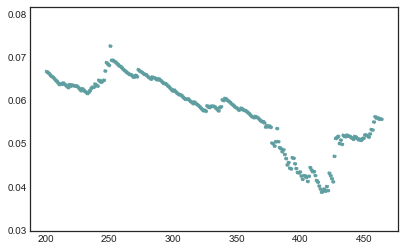

In [107]:
#expnames = ["190617_probs_noaug_sample", "190617_probs_aug_nosample", "190617_probs_aug_sample", "190617_probs_noaug_nosample"]
expnames = ["190617_probs_aug_sample"]
plot_dir = "../plots/"

for expname in expnames:
    filename = "../src/memoization/outputs/{}".format(expname)
    plot_guesses_tmp(expname, filename, plot_dir)